In [1]:
from IPython.display import clear_output

!pip install -q tensorflow==2.4.1

clear_output()

import os
import shutil
import random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


physical_devices = tf.config.list_physical_devices("GPU")

seed = 1
random.seed(seed)
directory = '../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
images_path = Path('../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/')
path_ground_truth_data = '../input/isic-2019/ISIC_2019_Training_GroundTruth.csv'

# Look to the ground truth label

In [2]:
ground_truth_labels = pd.read_csv(path_ground_truth_data)
print(ground_truth_labels.head())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [3]:
CLASSES = ground_truth_labels.columns[1:-1].values
print(CLASSES)

['MEL' 'NV' 'BCC' 'AK' 'BKL' 'DF' 'VASC' 'SCC']


In [4]:
ground_truth_labels.image.nunique()

25331

# Get path images and get labels from ground_truth_labels

In [5]:
images = [path.as_posix() for path in list(images_path.rglob("*jpg"))]
labels = list()
for path in tqdm(images):
    name = path.split('/')[-1].split('.')[0]
    label = ground_truth_labels[ground_truth_labels.image == name].iloc[:,1:].values.argmax()
    labels.append(label)
classes = len(np.unique(labels))
assert len(images)==len(labels), 'Not equal number images and labels'


100%|██████████| 25331/25331 [01:55<00:00, 219.33it/s]


# Distribution label in train test

25331 25331


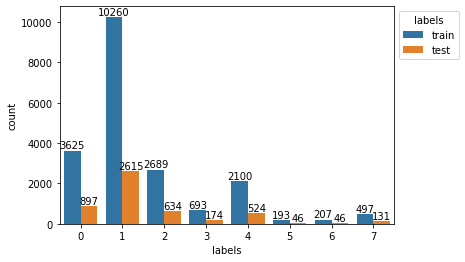

In [6]:
number_validation_images = int(len(images) * 0.8)
train_images, train_labels = images[:number_validation_images], labels[:number_validation_images]
test_images, test_labels = images[number_validation_images:], labels[number_validation_images:]

cur_labels = train_labels + test_labels
splits = ['train' for _ in range(len(train_labels))] + ['test' for _ in range(len(test_labels))] 
print(len(labels), len(splits))
df = pd.DataFrame(list(zip(cur_labels, splits)),
               columns =['labels', 'splits'])

p = sns.countplot(data=df, x='labels', hue='splits')
p.legend(title='labels', bbox_to_anchor=(1, 1), loc='upper left')

for c in p.containers:
    # set the bar label
    p.bar_label(c, fmt='%.0f', label_type='edge')

# Create Dataset

In [7]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [260, 260], 'nearest')
#     image /= 255
    return image

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label   

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label


train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)\
                   .map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(2048).batch(10).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(10).prefetch(tf.data.AUTOTUNE)

# Train image - label 

In [8]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

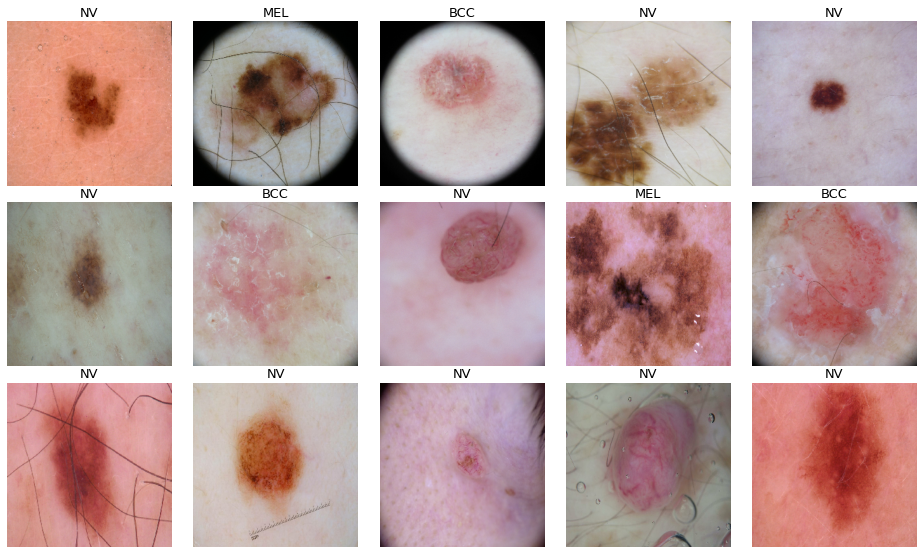

In [9]:
ds_iter = next(iter(train_ds.unbatch().batch(15)))
display_batch_of_images(ds_iter)

# test image - label

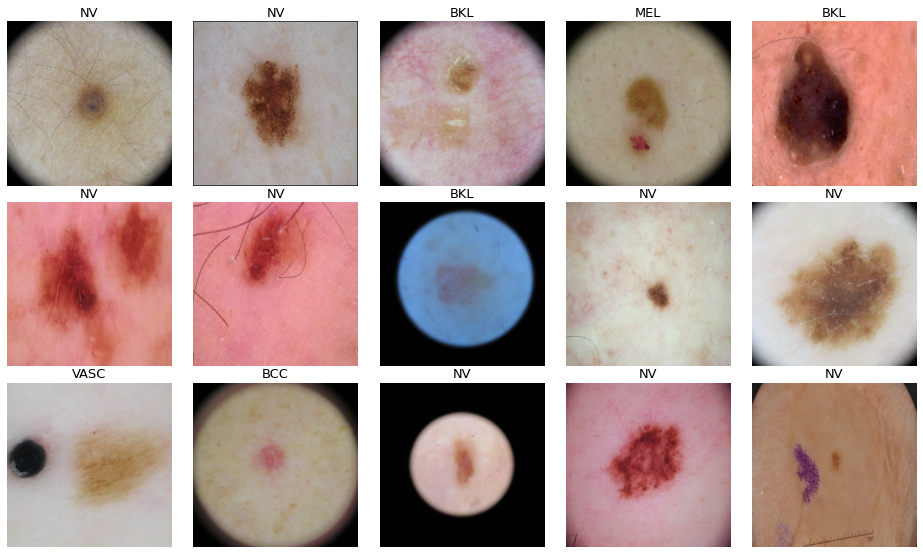

In [10]:
ds_iter = next(iter(test_ds.unbatch().batch(15)))
display_batch_of_images(ds_iter)

Learning rate schedule: 1e-05 to 5e-05 to 1e-05


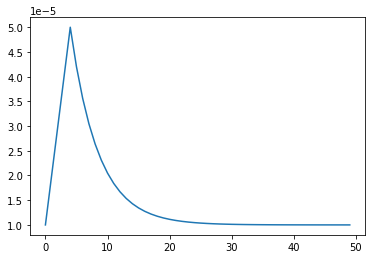

In [11]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 50

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [12]:
from tensorflow import keras
model = keras.applications.EfficientNetB2(include_top=True)

# for input you can also do model.input,
# then for base_outputs you can obviously
# choose other than simply removing the last one :)
base_inputs = model.layers[0].input
base_outputs = model.layers[-1].output
classifier = layers.Dense(classes)(base_outputs)
new_model = keras.Model(inputs=base_inputs, outputs=classifier)


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=False),],
    metrics=["sparse_categorical_accuracy"],
)


history = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=2,
    epochs=EPOCHS,
    verbose=1,
    callbacks=lr_callback,
)

37437440/37432240 [==============================] - 0s 0us/step
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
2027/2027 [==============================] - 561s 261ms/step - loss: 3.9619 - sparse_categorical_accuracy: 0.3456 - val_loss: 1.0528 - val_sparse_categorical_accuracy: 0.6748
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 2e-05.
2027/2027 [==============================] - 505s 245ms/step - loss: 1.0515 - sparse_categorical_accuracy: 0.6503 - val_loss: 0.7973 - val_sparse_categorical_accuracy: 0.7233
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 3.0000000000000004e-05.
2027/2027 [==============================] - 504s 245ms/step - loss: 0.8346 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.6980 - val_sparse_categorical_accuracy: 0.7501
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 4e-05.
2027/2027 [==============================] - 503s 244ms/step - loss: 0.73

In [13]:
model.save('model.h5')

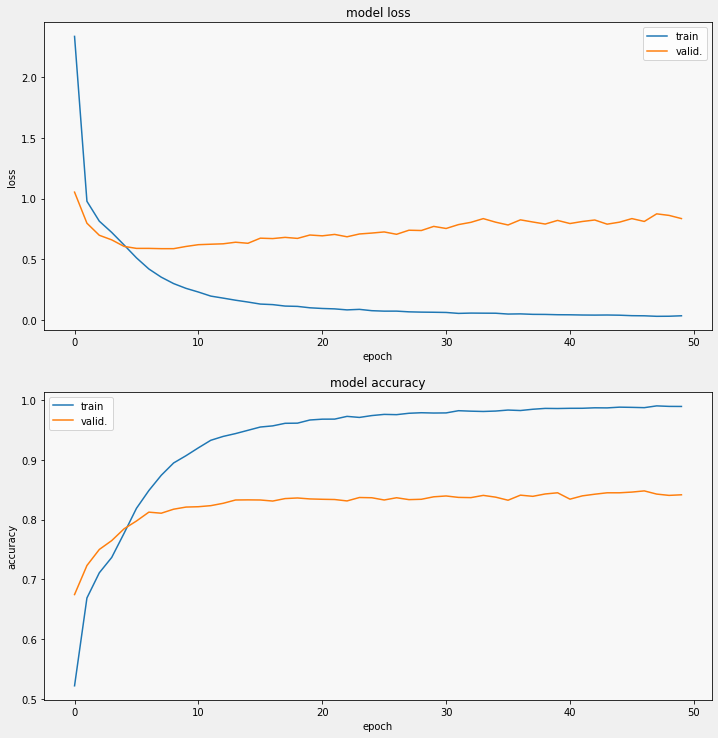

In [14]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

# Evaluate Predictionss


In [15]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Visual prediction

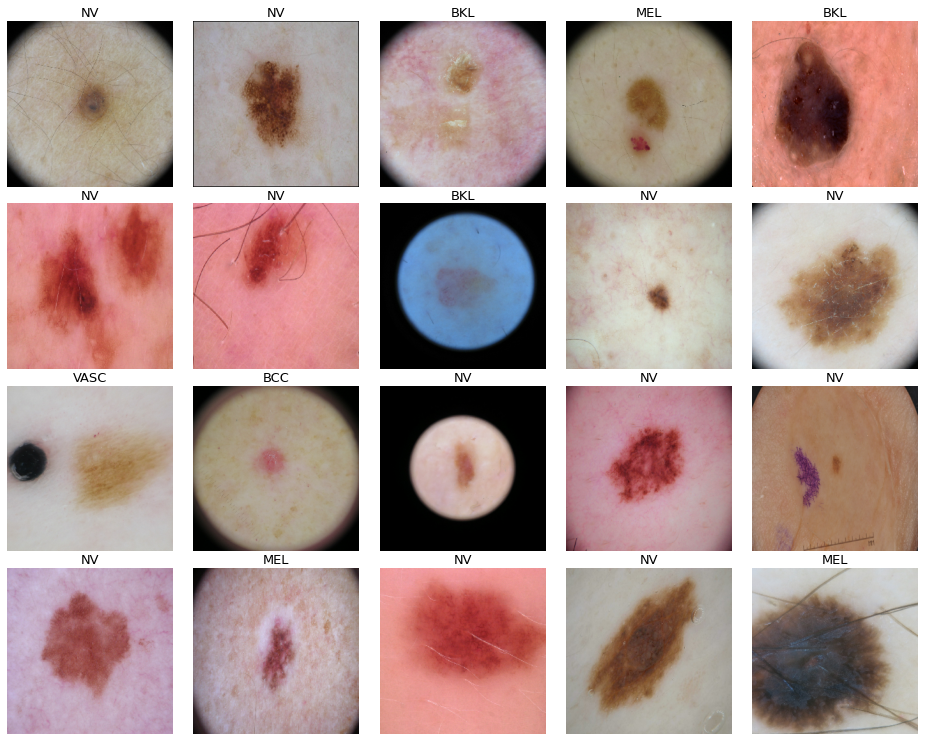

In [16]:
dataset = test_ds.unbatch().batch(20)
batch = iter(dataset)

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)